<a href="https://colab.research.google.com/github/kumiori/mec647/blob/andres-conerecipe/playground/nb/discrete_stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

import yaml
import hashlib

def load_data(rootdir):

	# with open(rootdir + '/parameters.pkl', 'r') as f:
	# 	params = json.load(f)

	with open(rootdir + '/parameters.yaml') as f:
		params = yaml.load(f, Loader=yaml.FullLoader)

	with open(rootdir + '/time_data.json', 'r') as f:
		data = json.load(f)
		dataf = pd.DataFrame(data).sort_values('load')

	if os.path.isfile(rootdir + '/signature.md5'):
#         print('sig file found')
		with open(rootdir + '/signature.md5', 'r') as f:
			signature = f.read()
	else:
		print('no sig file found')
		signature = hashlib.md5(str(params).encode('utf-8')).hexdigest()

	return params, dataf, signature 

In [7]:

branch_name = 'main'
branch_name = 'andres-conerecipe'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
#   sys.path.append('mec647/')

except Exception as e:
  print('Something went wrong', e)
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git



Cloning into 'mec647'...
remote: Enumerating objects: 2167, done.
remote: Counting objects: 100% (900/900), done.
remote: Compressing objects: 100% (364/364), done.
remote: Total 2167 (delta 555), reused 821 (delta 494), pack-reused 1267
Receiving objects: 100% (2167/2167), 96.76 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (1186/1186), done.


In [5]:
## Simple Analytic 
α, α1, α2, e1, e2 = sp.symbols('α α1 α2 e1 e2')
u1, u2 = sp.symbols('u1 u2')
K1, K2 = sp.symbols('K1 K2', positive=True)
s1, s2 = sp.symbols('s1 s2', positive=True)
μ, N = sp.symbols('μ N', positive=True)
w1 = sp.symbols('w1', positive=True)
t = sp.Symbol('t', positive=True)
k = sp.Symbol('k', positive=True)

# _N = 2

K = lambda α: (1-α)/(1+(k-1)*α)
s = lambda α: 1/K(α)

U = 1/2*μ*(K1*u1**2 + K2*(t-u1)**2) * N

S = w1*(α1 + α2) / N

sol_u = sp.solve(U.diff(u1), u1)



In [8]:
!ls mec647/practice/output

discrete-atk-N2  discrete-atk-N3


### Example: material parameters

In [10]:
model_parameters

{'N': 2,
 'ell': 0.1,
 'k': 3,
 'k_res': 0.0001,
 'model_dimension': 1,
 'model_type': '1D',
 'mu': 1,
 'w1': 1}

In [11]:
_params = {
    'N': 2,
    'k': 4,
    'k_res': 0.0001,
    'model_dimension': 1,
    'model_type': '1D-discrete',
    'mu': 1,
    'w1': 2}


experiment = 'mec647/practice/output/discrete-atk-N2'
params, data, signature = load_data(experiment)
model_parameters = params.get("model")

_mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get("w1"), model_parameters.get("k"), model_parameters["N"]

# _mu, _w1, _k, _N = _params.get("mu"), _params.get("w1"), _params.get("k"), _params["N"]

matpar = {k: _k, w1: _w1, N: _N, μ: _mu}
matpar

{k: 3, w1: 1, N: 2, μ: 1}

In [13]:
E=U.subs(u1, sol_u[0]).simplify()
E

0.5*K1*K2*N*t**2*μ/(K1 + K2)

## Setup

$$
E(u):=\frac{1}{2} N\mu\sum_{i=1}^N a_k(\alpha_i)(u_{i}-u_{i-1})^2 + \frac{w_1}{N} \sum_{i=1}^N w(\alpha_i)
$$

In [8]:
N = sp.symbols("N", integer=True)
t = sp.symbols('t')
_N = 3

γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')

u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
α = sp.symbols([f"α{i}" for i in range(1, _N+1)])


In [10]:
state = {"u": u, "α": α, "e": e}
_matpar = {N: _N, γ: 2, "E0": 1, "w1": 1, "L": 1}
matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}



In [44]:
class DiscreteDamage():
    def __init__(self, state, matpar, 
                 name = "discrete linear-softening",
                 slug = "linear-softening"):
        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug

    def _s(self, αi):
        return 1/self._a(αi)
        

    def _w(self, αi):
        return αi

    def _a(self, αi):
        γ = self.matpar["γ"]

        return (1 - self._w(αi)) / ((γ-1) * self._w(αi) + 1)

    def _elastic(self, state):
        _e = state["e"]
        _α = state["α"]
        # _w1 = matpar["w1"]
        _E0 = self.matpar["E0"]
        _N = self.matpar["N"]
    
        return sum([1./2. * _E0 * _N * self._a(_α[i]) * _e[i]**2 for i in range(len(_α))]) 
    
    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _damage(self, state):
        _α = state["α"]
        _w1 = self.matpar["w1"]

        _N = self.matpar["N"]

        return sum([_w1 / _N * self._w(_α[i]) for i in range(len(_α))]) 
        # return _w1 * self._w(_α)

    def __str__(self):
     return self.str

class ModelAnalysis:
    """Helper class to analyse stability properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        _state = self.state
        self.matpar = model.matpar

        self._s = 1/self.model._a(_state[α])
        self._sp = sp.diff(self._s, _state[α], 1)
        self._spp = sp.diff(self._s, _state[α], 2)

        self._a = self.model._a(_state[α])
        self._ap = sp.diff(self._a, _state[α], 1)
        self._app = sp.diff(self._a, _state[α], 2)

        self._w = self.model._w(_state[α])
        self._wp = sp.diff(self._w, _state[α])
        self._wpp = sp.diff(self._w, _state[α], 2)
        self.criterion()

    def _print_model_functions(self, matpar = {}):
        if matpar == {}:
            _fname = f"model-{self.model.slug}.txt"
        else: 
            _fname = f"model-{self.model.slug}-matpar.txt"
        print(f"Output in {_fname}")

        sp.latex(self._a)
        sp.latex(self._ap)
        sp.latex(self._app)
        sp.latex(self._s)
        sp.latex(self._sp)
        sp.latex(self._spp)
        
        _fcs = [self._a.subs(matpar), 
            self._ap.subs(matpar), 
            self._app.subs(matpar), 
            self._s.subs(matpar), 
            self._sp.subs(matpar), 
            self._spp.subs(matpar)]
        _lab = ["a", "aprime", "apprime", "s", "sprime", "spprime"]
        _known = ["a(\\alpha)=", "a'(\\alpha)=", "a''(\\alpha)=", 
                "s(\\alpha)=", "s'(\\alpha)=", "s''(\\alpha)="]

        out_file = open(_fname,"w")
        
        for y in zip(_fcs, _lab, _known):
            _tex = y[2] + str(sp.latex(y[0])).replace("α", "\\alpha")
            out_file.write("\\begin{equation}")
            out_file.write(f"\\label{{ eqn:{self.model.slug}-{y[1]} }}")
            out_file.write(_tex)
            out_file.write("\\end{equation}")
            out_file.write("\n")

        out_file.close()

        _σ = sp.symbols('σ')
        _β = sp.symbols('β')
        _α0 = sp.symbols('α0')
        _γ = sp.symbols('γ')
        _E0 = self.model.matpar[E0]

        _fch = self._H_damage_profile()

        fc0 = self.criterion()
        fc1 = self.critical_load(matpar)
        fc3 = _fch.subs(matpar).subs({_β: -_γ/_α0+1})
        fc4 = (1/sp.sqrt(
                _fch.subs(matpar))
                ).simplify()
        fc5 = ((self._s - 1/E0).subs(α, _β)/sp.sqrt(_fch))    \
            .subs(matpar)                                              \
            .simplify()

        fc6 = (((self._s - 1/E0).subs(α, _β)/sp.sqrt(_fch)))    \
            .subs(matpar).subs({_β: -_γ/_α0+1})                \
            # .simplify()
        
        fc7 = _fch.subs(matpar).subs({_β: -_γ/_α0+1})
        fc7_γ = sp.diff(fc7, _γ).subs({_γ: 1}).simplify()
        # Hσγ_γ.simplify()
        fc6_γ = sp.diff(fc6, _γ).subs({_γ: 1}).subs(matpar).simplify()

        _fcs = [fc0, fc1, _fch, 
                # fc2, 
                fc3, fc4, fc5, fc6, fc7, fc7_γ, fc6_γ]
        _lab = ["crit", "crit_load", "Hsigmabeta", 
                # "Hsigmagamma", 
                "Hsigmabeta_mat", "one_over_H",
                "eps_integrand", 
                "eps_integrand_gamma", 
                "deriv_integrand_gamma", 
                "deriv_integrand_gamma_one", 
                "deriv_integrand_gamma_one", 
                ]
        _known = ["0=", "t_c=", 
                "H(\\sigma, \\beta)=", 
                # "H(\\sigma, \\beta)=",
                "H(\\sigma, \\gamma)=",
                "1/\\sqrt{H(\\sigma, \\beta)}=",
                "(S(\\beta)-S_0)/\\sqrt{H(\\sigma, \\beta)}=",
                "(S(\\gamma)-S_0)/\\sqrt{H(\\sigma, \\gamma)}=",
                "\\frac{\\partial H}{\\partial \\gamma}=",
                "\\frac{\\partial H}{\\partial \\gamma}|_{\\gamma=1}=",
                "\\frac{\\partial 1/\\sqrt{H}}{\\partial \\gamma}|_{\\gamma=1}="
                ]

        out_file = open(_fname,"a")
        out_file.write("\n")
        
        for y in zip(_fcs, _lab, _known):
            print(y[2])
            _tex = y[2] + str(sp.latex(y[0])).replace("α", "\\alpha") \
                                    .replace("σ", "\\sigma")    \
                                    .replace("β", "\\beta")    \
                                    .replace("γ", "\\gamma")    
            out_file.write("\\begin{equation}")
            out_file.write(f"\\label{{ eqn:{self.model.slug}-{y[1]} }}")
            out_file.write(_tex)
            out_file.write("\\end{equation}")
            out_file.write("\n")

        out_file.close()

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        _u0 = t*x/L
        _alpha0 = 0

        _crit = sp.diff(model.energy(state), α) \
            .subs({u: _u0, α: _alpha0})         \
            .simplify()
        # .subs(matpar).simplify()
        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def critical_load(self, matpar = {}):
        ans = sp.solve(self.crit, t)
        _ = [t.subs(matpar) for t in ans]
        positive = np.where(np.array(_) >= 0)[0][0]
        # pdx
        self._critical_load = ans[positive]
        return ans[positive]

    def critical_load_N(self, _matpar={}):
        return np.float64(self._critical_load.subs(_matpar))

    def _homogeneous_energy(self, _matpar):
        state, (_uf, _af) = self._homogeneous_state(_matpar)

        _u = state[0]
        _alpha = state[1]

        return

    def set_critical_load(self, _critical_load):
        """If needed, set the critical load explicitly and manually"""
        self._critical_load = _critical_load

    def _check_constitutive(self):
        _a = 1
        # a -> E(a) decreasing
        # a -> w(a) increasing
        # a -> -w'/E' increasing
        # a -> -w'/s' decreasing
        return

    def _homogeneous_alpha(self, matpar = None):
        _u0 = t*x/L

        if matpar is not None:
            _matpar = matpar
        else:
            _matpar = self.matpar

        try:
            _eq = sp.diff(self.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify()

            _ah = sp.solve(_eq, α)

        # except NotImplementedError as e:
        except:
            _eq = sp.diff(ana.model.energy(state), α)   \
                .subs({u: _u0, α: α})                   \
                .subs(_matpar)                   \
                .simplify()

            _ah = sp.solve(_eq, α)

        return _ah
    
    def _homogeneous_state(self, _matpar={}, ah=None):
        if ah is None:
            # Good luck with the first solution
            _ah = self._homogeneous_alpha()[0]
        else:
            _ah = ah
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load

        x, t = sp.symbols('x t')
        print(_tc)
        _homogeneous_alpha = sp.Piecewise((_ah, t >= _tc), (0, t < _tc))
        _homogeneous_u = t * x / L

        _uf = sp.lambdify((t, x), _homogeneous_u.subs(_matpar), "numpy")
        _af = sp.lambdify(t, _homogeneous_alpha.subs(_matpar), "numpy")

        state = {u: _homogeneous_u, α: _homogeneous_alpha}

        return state, (_uf, _af)

    def _set_homogeneous_alpha(self, ah):
        self._alpha_h = ah

        return

    def plot_homogeneous_alpha(self, _matpar={}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        subcritical_times = np.linspace(0., _tc)
        axis.plot(subcritical_times, [0 for t in subcritical_times], c="C0")

        supercritical_times = np.linspace(_tc, 3)

        for _a in ah:
            _af = sp.lambdify(t, _a.subs(_matpar), "numpy")

            axis.plot(supercritical_times, [_af(t)
                      for t in supercritical_times], c="C0")
            # plt.plot()

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        return fig, axis

    def plot_homogeneous_stress(self, _matpar={}, ah=None):
        ah = self._homogeneous_alpha()
        # _tc = self.critical_load_N(_matpar)
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load
        print(f"_tc {_tc}")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        times = np.linspace(0, 3, 30)

        _sf = sp.lambdify(t, self._stress(ah=ah).subs(_matpar), "numpy")

        # axis.plot(np.linspace(0, 3), [_sf(t) for t in times], c="C0")
        axis.plot(_times, [_sf(t) for t in _times], c="C0")

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        return fig, axis

    def plot_homogeneous_energies(self, _matpar):

        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar)

        _en_h = sp.lambdify(t, at1.energy(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        plt.plot(np.linspace(0., 3.), [_en_h(t)
                 for t in np.linspace(0., 3.)], c="C0")
        plt.plot(np.linspace(0., 3.), [_en_dam_h(t)
                 for t in np.linspace(0., 3.)], c="C1")
        plt.plot(np.linspace(0., 3.), [_en_ela_h(t)
                 for t in np.linspace(0., 3.)], c="C2")

        return fig, axis

    def plot_material(self, _matpar):
        _damage = np.linspace(0., 1.)

        _wf = sp.lambdify(α, self._w.simplify().subs(_matpar), "numpy")
        _af = sp.lambdify(α, self._a.simplify().subs(_matpar), "numpy")
        _apf = sp.lambdify(α, self._ap.simplify().subs(_matpar), "numpy")
        _appf = sp.lambdify(α, self._app.simplify().subs(_matpar), "numpy")

        # _apf = sp.lambdify(t, ana.)ap.subs(_matpar), "numpy")
        # _apf

        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c='k')
        _ax.plot(_damage, [_af(α) for α in _damage], label="a")
        _ax.legend(loc=2)
        _ax.plot(_damage, [_apf(α) for α in _damage], label="a'", c='r')
        _ax.plot(_damage, [_appf(α) for α in _damage], label="a''")
        # _ax2 = _ax.twiny()
        left, bottom, width, height = [0.25, 0.5, 0.2, 0.2]
        _ax2 = figure.add_axes([left, bottom, width, height])

        _ax2.plot(_damage, [_wf(α) for α in _damage], label="w", c='k', ls='dashed')

        _ax.set_xlim(0, 1)
        _ax2.set_xlim(0, 1)
        # _ax2.set_ylim(0, 1)
        _ax.legend()
        _ax2.legend(loc=3)

        _sf = sp.lambdify(α, self._s.simplify().subs(_matpar), "numpy")
        _spf = sp.lambdify(α, self._sp.simplify().subs(_matpar), "numpy")
        _sppf = sp.lambdify(α, self._spp.simplify().subs(_matpar), "numpy")

        _ax = axis[1]

        _ax.plot(_damage, [_sf(α) for α in _damage], label="s")
        _ax.legend(loc=2)
        _ax.axhline(0, c='k')
        _ax.twinx()
        _ax.plot(_damage, [_spf(α) for α in _damage], label="s'")
        _ax.plot(_damage, [_sppf(α) for α in _damage], label="s''")
        _ax.set_xlim(0, 1)
        _ax.set_ylim(0, 10)
        _ax.legend(loc=1)
        figure.suptitle(f"Behaviour of {self.model.__str__()} is Material")

        return figure, axis

    def _hypotheses1(self):
        """As per marigo-2012, HP1: w'/S' decreasing wrt alpha"""

        _hp1 = self._sp / self._wp
        return _hp1

    def _H_damage_profile(self):
        """A function of sigma and beta constructs localisation profiles"""
        _σ = sp.symbols('σ')
        _β = sp.symbols('β')

        _Hf = 1/E0*(2*self._w - _σ**2 * (self._s - 1/E0)).subs({α: _β})

        return _Hf

    def max_α(self, matpar = {}):
        """Maximum value of alpha as a function of sigma, returns 
        real solutions and the index of admissible solutions in [0, 1]"""
        _β = sp.symbols('β')
        _σ = sp.symbols('σ')
            
        sol = sp.solve(self._H_damage_profile().subs(matpar), _β)

        # simple tet
        arr = np.array([a.subs({_σ: .9}) for a in sol])
        real_filter = [sp.N(a).is_real for a in arr]
        sol = np.compress(real_filter, sol)
        r_arr = np.array([a.subs({_σ: .9}) for a in sol])
        idx = np.argwhere((r_arr > 0) & (r_arr < 1)).flatten()[0]

        return sol, idx

    def _α_max(self, σ, matpar = None):
        _β = sp.symbols('β')
        _σ = sp.symbols('σ')
        # _matpar = self.matpar
        _Hσβ = self._H_damage_profile().subs(matpar)

        _Hβ = _Hσβ.subs({_σ: σ})
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect')
        # print(_sol)
        αmax = np.float64(_sol[1][0])

        return αmax

    def _integrate_Hminusonehalf(self, σv, H):
        _σ = sp.symbols('σ')
        _fv = sp.lambdify(_γ, ((H.subs({_σ: σv}))**(-1/2)), "numpy")
        return _integ.quad(_fv, 0, 1)

    def _integrate_Dsigma(self, σv, H = None, matpar = {}):
        _σ = sp.symbols('σ')
        sol, idx = self.max_α(matpar)

        if H is not None:
            _bar_H = H.subs(matpar)
        else:    
            _bar_H = self._H_damage_profile().subs(matpar)    \
                .subs({_β: _γ*_α0})                 \
                .subs({_α0: sol[idx]}).simplify()
            
        _f = ((_bar_H)**(-1/2)*sol[idx]).subs({_σ: σv})
        _fv = sp.lambdify(_γ, _f, "numpy")
        return _integ.quad(_fv, 0, 1)

    def _integrate_epsilon_localised(self, σv, H = None, matpar = {}):
        _σ = sp.symbols('σ')
        sol, idx = self.max_α(matpar)

        if H is not None:
            _bar_H = H.subs(matpar)
        else:    
            _bar_H = self._H_damage_profile().subs(matpar)    \
                .subs({_β: _γ*_α0})                         \
                .subs({_α0: sol[idx]}).simplify()
        
        _prefact = (self._s - 1/E0).subs(matpar)            \
                .subs({_α: _γ*_α0})                         \
                .subs({_α0: sol[idx]}).simplify()
        
        _f = (2*_prefact*(_bar_H)**(-1/2)*sol[idx]).subs({_σ: σv})
        _fv = sp.lambdify(_γ, _f, "numpy")
        return _integ.quad(_fv, 0, 1)

    def _stress(self, ah=None):
        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar, ah=ah)

        _ah = _homog_state[α]

        _tc = self.critical_load_N(_matpar)

        stress_alpha = sp.Piecewise(
            (sp.sqrt(2 * self._wp / self._sp).subs({α: _ah}), t >= _tc),
            # sigma = E(alpha=0) u'
            (sp.diff(_homog_state[u], x).subs(_matpar), t < _tc))

        # return sp.sqrt( 2* self._wp / self._sp).subs({α: _ah})
        return stress_alpha

    def _Dσ(self, σ):
        """Half length of the localisation as a function of σ"""
        _αh = self._homogeneous_alpha()
        _γ = sp.symbols('γ')
        _αmax = self._α_max(σ)

        _E0 = self.model._matpar[E0]
        _𝓁 = self.model._matpar[𝓁]

        _f = 1/self._H_damage_profile()

        _Dσ = _𝓁 * sp.integrate(_f, (_β, 0, _αmax))

    def D0(self, matpar):
        """Half length of the localisation as a function of σ, (in the limit) sigma = 0"""
        _γ = sp.symbols('γ')
        _i = (((2*self._w)/E0)**(-1/2)).subs({α: _γ}).subs(matpar) 
        _fv = sp.lambdify(_γ, _i, "numpy")

        return _integ.quad(_fv, 0, 1)

    def _σc(self, matpar):
        return sp.sqrt(2*self._wp/self._sp).subs(matpar).subs({α: 0})

    def _Dc(self, matpar):
        """Half length of the localisation at the onset"""

        _sigma0 = self._σc(matpar)
        _D = np.pi * \
            sp.sqrt(2 * E0 / (_sigma0**2 * self._spp - 2.*self._wpp)) \
                .subs({α: 0}).subs(matpar)

        return _D
    
    def localised_deformation(self, matpar):

        sol, idx = self.max_α(matpar)

        _H_subs = self._H_damage_profile().subs(matpar)    \
                .subs({_β: _γ*_α0})                             \
                .subs({_α0: sol[idx]}).simplify()

        _integrand = 2*((self._s - 1/E0)*_H_subs**(-1/2))         \
                .subs({α: _γ*_α0})                             \
                .subs(matpar)                              \
                .subs({_α0: sol[idx]}).simplify()
        
        _fv = sp.lambdify(_γ, (_integrand.subs({_σ: σv})), "numpy")
        
        return _integ.quad(_fv, 0, 1)

    def snap_back(self, matpar):
        _α = self.model.state[α]
        _E0 = self.model.matpar[E0]
        _w1 = self.model.matpar[w1]
        S0 =  1 / _E0
        _σc = sp.sqrt( 2* self.model.matpar[w1]*self._wp / (S0*self._sp) ).subs({α: 0})
        _sp = self._sp
        _w = self._w

    def _eps_1_d(self, σv, matpar, tol = 1e-3):
        # _β = sp.symbols('β')
        # _α_max = self._α_max(σv, matpar)
        # _f = (self._s - 1/E0).subs(α, _β)/sp.sqrt(self._H_damage_profile())    \
        #     .subs(matpar)                                                   \
        #     .subs({_σ: σv})                                                   \
        #     .simplify()

        # __fv = sp.lambdify(_β, f.subs(matpar), "numpy")
        # _tol = 0.001
        _betas = np.linspace(_tol, _α_max - tol, 30)
        _f, _α_max, __fv = self._eps_1_d_integrand(σv, matpar)
        eps = np.trapz([__fv(b) for b in _betas], _betas)

        return eps, (_f, _α_max)

    def _eps_1_d_integrand(self, σv, matpar):
        _β = sp.symbols('β')
        _α_max = self._α_max(σv, matpar)

        _f = ((self._s - 1/E0).subs(α, _β)/sp.sqrt(self._H_damage_profile()))    \
            .subs(matpar)                                                       \
            .subs({_σ: σv})                                                   \
            .simplify()

        __fv = sp.lambdify(_β, _f.subs(matpar), "numpy")

        return _f, _α_max, __fv




        return - ((np.pi * 2**(5/2) * (S0 * _sp)**2 * _σc**2 * _E0**1/2) /
                  (S0*self._spp * _σc**2 - 2. * _w1 * self._wpp) ** (3/2))       \
                    .subs({α: 0}).subs(matpar)

    # check: dependence of localisation zone wrt stress
    # check: global maccro response

    def _plot_H_Hminusonehalf_alphamax(self, matpar):
        figure, axis = plt.subplots(1, 2, figsize=(10, 6))
        figure.tight_layout()
        # figure.subplots_adjust(left  = 0.125, 
        #     right = 1  ,  
        #     bottom = 0.1 ,  
        #     top = 1    ,  
        #     wspace = .9 ,  
        #     hspace = 0.2 
        #     )

        _tol = 1e-4

        sol, idx = self.max_α(matpar)

        _bar_H = self._H_damage_profile().subs(matpar)    \
            .subs({_β: _γ*_α0})                 \
            .subs({_α0: sol[idx]})

        _bar_H
        ax2 = axis[0].twinx()

        for σv in np.linspace(.99, .01, 10):
            _fv = sp.lambdify(_γ, (_bar_H.subs({_σ: σv})), "numpy")
            axis[0].plot(_damage, [_fv(b) for b in _damage], label = f"$\sigma/\sigma_0$  = {σv:.2f}")
            ax2.plot(_damage, [(_fv(b))**(-1/2) for b in _damage], lw=1, c='gray')

        # ax2.set_yticks([])
        ax2.set_ylim(0, 10)

        # , marker = 'o'
        axis[0].set_xlabel("$\\beta/\\bar \\alpha$")
        axis[0].legend()

        amax = []
        for i in np.linspace(.999, .01, 10):
            amax.append(self._α_max(i, _matpar))


        axis[1].plot(amax, np.linspace(1, .0, 10), marker='o')
        axis[1].set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
        axis[1].set_ylabel('$\\sigma/\\sigma_0$')
        axis[1].set_xlim(0., 1.)
        # axis[1].set_title(f"{self.model}")

        _fc = sol[idx]
        # sol[idx]
        _fv = sp.lambdify(_σ, _fc, "numpy")
        _sigmas = np.linspace(1, .0, 10)
        axis[1].plot([_fv(s) for s in _sigmas], _sigmas, label = "analytic")

        axis[1].legend()
        figure.suptitle(f"{self.model}")

        return figure, axis

class DiscreteAnalysis(ModelAnalysis):
    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

    def s(self, _α):
        return 1/self.model._a(_α)

        # self._s = 1/self.model._a(state[α])
        # self._sp = sp.diff(self._s, state[α], 1)
        # self._spp = sp.diff(self._s, state[α], 2)

        # self._a = self.model._a(state[α])
        # self._ap = sp.diff(self._a, state[α], 1)
        # self._app = sp.diff(self._a, state[α], 2)

        # self._w = self.model._w(state[α])
        # self._wp = sp.diff(self._w, state[α])
        # self._wpp = sp.diff(self._w, state[α], 2)

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        # _u0 = t*x/L
        _alpha0 = 0

        _crit = sp.diff(self.model.energy(state), α[0])     \
            .subs({α[0]: _α})                               \
            .subs({e[0]: _eh})

        # .subs(matpar).simplify()
        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def _energy_fc_alpha(self):
        _model, _state = self.model, self.state
        _en = _model._elastic(_state) + _model._damage(_state)
        _S = sum([self.s(_state["α"][i]) for i in range(len(_state["α"]))]) 
        _ei = [(t/L * _model._s(_state["α"][i]) / _S).simplify() \
            for i in range(len(_state["α"]))]

        # _subs_e_alpha = {v[0]: v[1] for v in zip(_state["e"], _ei)}
        _, _subs_e_alpha = self._state_equilibrium_substitutions()
        # print(_subs_e_alpha)
        return _en.subs(_subs_e_alpha)

    def _homogeneous_alpha(self, matpar = None):
        if matpar is not None:
            _matpar = matpar
        else:
            # _matpar = self.matpar
            _matpar = {}

        try:
            _eq = sp.diff(self.model.energy(state), α[0]) \
                .subs({α[0]: _α})         \
                .simplify()
            # print(_eq)
            _ah = sp.solve(_eq, _α)

        # except NotImplementedError as e:
        except:
            _eq = sp.diff(self.model.energy(state), α[0])   \
                .subs({α[0]: _α})                   \
                .subs(_matpar)                   \
                .simplify()

            _ah = sp.solve(_eq, _α)

        return _ah

    def _equilirbrium_e(self):
        α_state = self.state["α"]
        _model = self.model
        _S = sum([self.s(_a) for _a in α_state]) 
        _ei = [(t/L * _model._s(_a) / _S).simplify() \
                    for _a in α_state]

        return _ei

    def _homogeneous_e(self, m=0, matpar = None):
        # _α is ah the homogeneous alpha
        if matpar is not None:
            _matpar = matpar
        else:
            # _matpar = self.matpar
            _matpar = {}

        _S = sum([ self.s(state["α"][i]) for i in range(len(state["α"]))])
        
        if m == 0:
            _state_α = state["α"]
        else: 
            _bif = [state["α"][k+1] for k in range(m)]

            _state_α = list(set(state["α"]) - set(_bif))

        _eh = [t/L * 1 / _S * self.s(_state_α[i]) for i in range(len(_state_α))]
        
        return _eh
        # return _eh.subs({a: _α for a in α})

    def _state_split(self, m, state, matpar):
        assert m < matpar[N]
        _bif = [state["α"][k+1] for k in range(m)]
        _bif_e = [state["e"][k+1] for k in range(m)]

        _homo = set(state["α"]) - set(_bif)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif, _homo, _bif_e, _homo_e

    def _state_substitutions(self, m, state, matpar):
        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)

        _homo_e = set(state["e"]) - set(_bif_e)

        _subs_homo_α = {_h: _α for _h in _homo}
        _subs_homo_e = {_h: _eh for _h in _homo_e}

        return _subs_homo_α, _subs_homo_e

    def _state_homog_substitutions(self, m, state, matpar):
        assert m < matpar[N]

        _subs_αh = {a: _α for a in α}
        _subs_eh = {e: _eh for e in state["e"]}

        return _subs_αh, _subs_eh

    def _state_bifurcation_substitutions(self, m, state, matpar):
        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)
        _αb = sp.symbols("a^*")
        _eb = sp.symbols("e^*")
        _subs_αh = {a: _αb for a in _bif}
        _subs_eh = {e: _eb for e in _bif_e}

        return _subs_αh, _subs_eh

    def _state_equilibrium_substitutions(self):

        _ei = self._equilirbrium_e()

        subs_equil = {e: _ei[k] for k, e in enumerate(state["e"])}
        _subs_equil_alpha = {v[0]: v[1] for v in zip(state["e"], _ei)}

        return subs_equil, _subs_equil_alpha


In [45]:
datls = DiscreteDamage(state, matpar)
dana = DiscreteAnalysis(datls)


## Homogeneous response


In [46]:
_α = sp.symbols("a_h")
_eh = sp.symbols("e_h")


_subs_αh = {a: _α for a in α}
_subs_eh = {e: _eh for e in state["e"]}



### Equilibrium solution
$e_i = \frac{t}{L}\frac{s(\alpha_i)}{S}, \qquad S = \sum_i s(\alpha_i)$

Energy as a function of $\alpha$, substituting equilibrium deformation

In [47]:
_en_αN = dana._energy_fc_alpha()
_en_αN

0.5*E0*N*t**2*(1 - α1)*(α2 - 1)**2*(α3 - 1)**2*(α1*(γ - 1) + 1)/(L**2*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1))**2) + 0.5*E0*N*t**2*(1 - α2)*(α1 - 1)**2*(α3 - 1)**2*(α2*(γ - 1) + 1)/(L**2*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1))**2) + 0.5*E0*N*t**2*(1 - α3)*(α1 - 1)**2*(α2 - 1)**2*(α3*(γ - 1) + 1)/(L**2*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1))**2) + w1*α1/N + w1*α2/N + w1*α3/N

Homogeneous damage

In [48]:
_eq = sp.diff(_en_αN.subs(_subs_αh).subs({N: _N}), _α)
_eq.subs(_matpar).simplify()
# _eq

(1.0*a_h**2 + 2.0*a_h - 1.0*t**2 + 1.0)/(1.0*a_h**2 + 2.0*a_h + 1.0)

In [49]:
sp.solve(_eq.subs(_matpar).simplify(), _α)

[-t - 1.0, t - 1.0]

Localised branches

In [50]:
m = 1
assert(m < _N)

In [51]:
datls._elastic(state) + datls._damage(state)

0.5*E0*N*e1**2*(1 - α1)/(α1*(γ - 1) + 1) + 0.5*E0*N*e2**2*(1 - α2)/(α2*(γ - 1) + 1) + 0.5*E0*N*e3**2*(1 - α3)/(α3*(γ - 1) + 1) + w1*α1/N + w1*α2/N + w1*α3/N

Damage criterion

In [52]:
dana.criterion().simplify()

-0.5*E0*N*e_h**2*γ/(a_h*γ - a_h + 1)**2 + w1/N

In [53]:
dana._homogeneous_alpha(matpar=_matpar)[1]

(0.707106781186548*N*e1*sqrt(E0*w1*γ) - w1)/(w1*(γ - 1.0))

In [54]:
dana._homogeneous_e()[0]

t*(α1*(γ - 1) + 1)/(L*(1 - α1)*((α3*(γ - 1) + 1)/(1 - α3) + (α2*(γ - 1) + 1)/(1 - α2) + (α1*(γ - 1) + 1)/(1 - α1)))

Homogeneous state

In [55]:
_subs_αh, _subs_eh

({α1: a_h, α2: a_h, α3: a_h}, {e1: e_h, e2: e_h, e3: e_h})

In [56]:
datls.energy(state)

0.5*E0*N*e1**2*(1 - α1)/(α1*(γ - 1) + 1) + 0.5*E0*N*e2**2*(1 - α2)/(α2*(γ - 1) + 1) + 0.5*E0*N*e3**2*(1 - α3)/(α3*(γ - 1) + 1) + w1*α1/N + w1*α2/N + w1*α3/N

In [60]:

datls.energy(state).subs(_subs_eh).subs(_subs_αh)

_bif, _homo, _bif_e, _homo_e = dana._state_split(m, state, _matpar)
_subs_bif_α, _subs_bif_e = dana._state_bifurcation_substitutions(m, state, _matpar)
_subs_homo_α, _subs_homo_e = dana._state_substitutions(m, state, _matpar)
_subs_αh, _subs_eh = dana._state_homog_substitutions(m, state, _matpar)

_bif, _homo, \
_bif_e, _homo_e, \
_subs_bif_α, _subs_bif_e, \
_subs_homo_α, _subs_homo_e, \
_subs_αh, _subs_eh 


([α2],
 {α1, α3},
 [e2],
 {e1, e3},
 {α2: a^*},
 {e2: e^*},
 {α3: a_h, α1: a_h},
 {e3: e_h, e1: e_h},
 {α1: a_h, α2: a_h, α3: a_h},
 {e1: e_h, e2: e_h, e3: e_h})

In [61]:
_ = datls.energy(state).subs(_subs_αh).subs({N: _N})
# .subs({N: _N})
# .subs(_subs_eh).subs(_subs_αh)
# _.subs(_subs_eh2)
# .simplify()
_


1.5*E0*e1**2*(1 - a_h)/(a_h*(γ - 1) + 1) + 1.5*E0*e2**2*(1 - a_h)/(a_h*(γ - 1) + 1) + 1.5*E0*e3**2*(1 - a_h)/(a_h*(γ - 1) + 1) + a_h*w1

In [62]:
astate = dana.state["α"]
astate


[α1, α2, α3]

In [63]:
sum([dana.s(_a) for _a in astate]) 

(α3*(γ - 1) + 1)/(1 - α3) + (α2*(γ - 1) + 1)/(1 - α2) + (α1*(γ - 1) + 1)/(1 - α1)

In [64]:
_ei = dana._equilirbrium_e()
_ei


[t*(α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1)/(L*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1))),
 t*(α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1)/(L*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1))),
 t*(α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1)/(L*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1)))]

In [65]:
[e.subs(_subs_αh) for e in _ei]


[t/(3*L), t/(3*L), t/(3*L)]

In [66]:
subs_equil, _subs_equil_alpha = dana._state_equilibrium_substitutions()
subs_equil, _subs_equil_alpha

({e1: t*(α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1)/(L*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1))),
  e2: t*(α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1)/(L*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1))),
  e3: t*(α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1)/(L*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1)))},
 {e1: t*(α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1)/(L*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1))),
  e2: t*(α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1)/(L*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1))),
  e3: t*(α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1)/(L*((α1 - 1)*(α2 - 1)*(α3*(γ - 1) + 1) + (α1 - 1)*(α3 - 1)*(α2*(γ - 1) + 1) + (α2 - 1)*(α3 - 1)*(α1*(γ - 1) + 1)))})

Bifurcations

In [70]:
_αb = sp.symbols("a^*")
_eb = sp.symbols("e^*")


In [67]:
_bif, _subs_bif_α

([α2], {α2: a^*})

In [68]:
_homo

{α1, α3}

Determine evolution with bifurcation

In [72]:
_en_α = dana._energy_fc_alpha()

_eq = _en_α.subs(_subs_bif_α)
# _α, _eq
# _eq
sp.diff(_eq.subs(_subs_bif_α), _αb).subs(_matpar).simplify()

(9.0*t**2*(a^* - 1)*(α1 - 1)*(α3 - 1)*((α1 - 1)*(α3 - 1) + (α1 - 1)*(α3 + 1) + (α1 + 1)*(α3 - 1)) + t**2*(α1 - 1)*(α3 - 1)*(4.5*(1 - a^*)*(α1 - 1)*(α3 - 1) - 9.0*(a^* - 1)*(α1 - 1)*(α3 + 1) - 9.0*(a^* - 1)*(α1 + 1)*(α3 - 1) - 4.5*(a^* + 1)*(α1 - 1)*(α3 - 1)) + ((a^* - 1)*(α1 - 1)*(α3 + 1) + (a^* - 1)*(α1 + 1)*(α3 - 1) + (a^* + 1)*(α1 - 1)*(α3 - 1))**2)/(3*((a^* - 1)*(α1 - 1)*(α3 + 1) + (a^* - 1)*(α1 + 1)*(α3 - 1) + (a^* + 1)*(α1 - 1)*(α3 - 1))**2)

Homogeneous elements

In [73]:
_subs_homo_α

{α3: a_h, α1: a_h}

In [76]:
_eq = _en_α.subs(_subs_homo_α)
(_eq.subs(_matpar)/_N).simplify()


(-0.5*t**2*(a_h - 1)**2*(α2 - 1)*(α2 + 1) - t**2*(a_h - 1)*(a_h + 1)*(α2 - 1)**2 + (2*a_h + α2)*((a_h - 1)*(α2 + 1) + 2*(a_h + 1)*(α2 - 1))**2/9)/((a_h - 1)*(α2 + 1) + 2*(a_h + 1)*(α2 - 1))**2

In [77]:
_eq = _en_α.subs(_subs_bif_α)

_c = sp.diff(_eq, _αb).subs(_matpar)
_ = _c.subs({_x : 0 for _x in _homo}).simplify()
_homogeneous_alpha_equil = sp.solve(_, _αb)
# sp.solve(_, _αb)
_homogeneous_alpha_equil
# _c

[3.0 - 3.0*t, 3.0*t + 3.0]

# legacy

In [14]:

_E = E.subs({K1: 1/s(α), K2: 1/s(α)})
_E

0.25*N*t**2*μ*(1 - α)/(α*(k - 1) + 1)

In [15]:
F = (E+S)
F = (E+S).subs({K1: 1/s(α), K2: 1/s(α), α1: α, α2: α})

F

0.25*N*t**2*μ*(1 - α)/(α*(k - 1) + 1) + 2*w1*α/N

### Critical damage load

In [16]:
Fa = F.diff(α).simplify()
Fa

-0.25*N*k*t**2*μ/(k*α - α + 1)**2 + 2*w1/N

In [17]:
Fa.subs({α: 0})

-0.25*N*k*t**2*μ + 2*w1/N

In [18]:
sp.solve(Fa, t)[1].subs({α: 0})

2.82842712474619*sqrt(w1)/(N*sqrt(k)*sqrt(μ))

In [22]:
_F = sp.lambdify((α, t), F.subs(matpar), 'numpy')
_F(0, 3)

4.5

In [23]:

tc = sp.solve(Fa, t)[1].subs({α: 0})
tc

2.82842712474619*sqrt(w1)/(N*sqrt(k)*sqrt(μ))

In [24]:
_tc = sp.N(tc.subs(matpar))
_tc

0.816496580927726

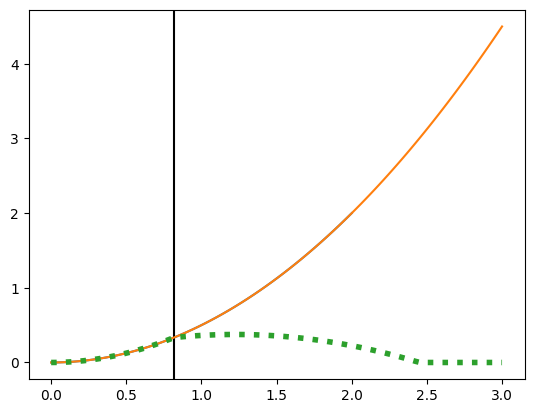

In [25]:
plt.plot(np.linspace(0., 2.), _F(0, np.linspace(0., 2.)))
plt.axvline(_tc, c='k')
plt.plot(data.load, _F(0, data.load.values))
plt.plot(data.load, data.elastic_energy, ls='dotted', lw=4)


### TODO

Verify cone-stability against the NLB theorem, devised by N based on some (few) numerical experiments featuring around 1m shots (each) into the uppermost-right quadrant. 

For some, those shots were random. 

We say: they were shot in the _target direction_, with a little bit of spice.


Targeting Abstract

FEniCSX conference

Pula (CA)

_thanks for choosing_

1. Verify homogeneous solution vs. N=2, 3, 4 computations
  1. compute analytic solution (_)
  1. extract displacement from system
  1. compute cone-stability of $H(\alpha)$ as a bilinear operator
  (which turns out to have ... entries if [and/or] only if the state is cone-stable. NLB Exp~theorem)
1. connect KR
1. target application: Ice Ice Baby (seek numerical collab) 
1. condense abstract
  1. make more abstract
  1. select a far-fetched appication or Antartica
1. double check with GL, FI, VC, PLC
  1. if Very good: triple check with QC, YCdB, LN
  1. else: submit